In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np

engagement_df = pd.read_csv('takehome_user_engagement.csv')
users_df = pd.read_csv('takehome_users.csv',encoding='latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
pandas_profiling.ProfileReport(users_df)

In [4]:
# Interpret time-stamp data and set it as index
engagement_df = engagement_df.set_index(pd.DatetimeIndex(engagement_df['time_stamp']))
# Determine the number of visits per week by user
visits_by_user = engagement_df.groupby('user_id').resample('1W').sum()
# Remove Null values
visits_by_user = visits_by_user[visits_by_user['user_id'].isnull()==False].drop('user_id',axis=1)
visits_by_user.head()

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0

In [5]:
# Now we determine active users based on who had 3 or more visits in at least one 7-day period
active_users = visits_by_user['visited']>=3
active_users = active_users.groupby(level=0).apply(np.sum)
# Remove all users who didn't meet the criteria 
active_users = active_users[active_users!=0]
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [6]:
# We will now combine the active users we isolated with the information associated with their accounts
active_user_data = active_users.merge(users_df,left_index=True,right_on='object_id',how='inner')
active_user_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [7]:
# Create a new column that marks active users
active_user_data['Active']=1

# Now we add this column to the original user dataframe
users_df['Active']=int(0)

# For every active user we identified, mark them in the original df
users_df.iloc[list(active_user_data.index),10]=1
compare_df = users_df.set_index('object_id').sort_index()

# Drop data that will not correlate to user adoption
compare_df = compare_df.drop([ 'name', 'email','last_session_creation_time', 'creation_time'],axis=1)
compare_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [8]:
# Fill NA and convert to numerical values
compare_df['invited_by_user_id'] = compare_df['invited_by_user_id'].fillna(0)
compare_df['invited_by_user_id'] = compare_df['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)
compare_df = pd.get_dummies(data=compare_df,columns=['creation_source'])

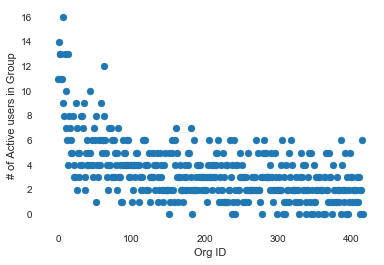

In [9]:
import seaborn
org = compare_df.groupby('org_id').sum()
plt.scatter(org.index,org.Active)
plt.ylabel('# of Active users in Group')
plt.xlabel('Org ID')
plt.show()

In [10]:
# We are going to create dummy variables for membership in a particular organization
org_cata = []
for i in compare_df['org_id']:
    cata = org.loc[i,'Active']
    org_cata.append(cata)
compare_df['org_id'] = org_cata

compare_df = pd.get_dummies(data=compare_df,columns=['org_id'])
compare_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
compare_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 25 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
invited_by_user_id                    12000 non-null int64
Active                                12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
org_id_0                              12000 non-null uint8
org_id_1                              12000 non-null uint8
org_id_2                              12000 non-null uint8
org_id_3                              12000 non-null uint8
org_id_4                              12000 non-null uint8
org_id_5                              12000 non-null uint8
org_id

In [12]:
# Now that we have all of the relevant information in one place, let's build a model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,train_test_split

y = compare_df.pop('Active')
x = compare_df

In [13]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2,random_state=108)

In [18]:
graboost = GradientBoostingClassifier(max_features='sqrt')
params = {'n_estimators':[35,40,45,50,55],'learning_rate':[.02,.03,.04,.05,.06],
              'max_depth':[1,2,3,4,5]}
grid = GridSearchCV(estimator=graboost,param_grid=params,
                     scoring='accuracy',cv=5)
grid.fit(x_train,y_train)
best_params = grid.best_params_
best_acc = grid.best_score_

print(f'Best Parameters :\n {best_params} \n with {best_acc*100} accuracy')

Best Parameters :
 {'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 35} 
 with 87.83333333333333 accuracy


In [19]:
gbm = GradientBoostingClassifier(max_features='sqrt',
                                 n_estimators=50,learning_rate=.05,max_depth= 3)
gbm.fit(x_train,y_train)
feature_coef = pd.DataFrame(gbm.feature_importances_).transpose()
feature_coef.columns = list(compare_df.columns)
feature_coef.index = ['GBM'] 
feature_coef.transpose().sort_values(by='GBM',ascending=False)

,GBM
creation_source_PERSONAL_PROJECTS,0.203346
org_id_5,0.143431
org_id_0,0.136069
org_id_1,0.108566
org_id_6,0.094909
org_id_11,0.081155
org_id_12,0.061816
creation_source_GUEST_INVITE,0.041223
creation_source_ORG_INVITE,0.024181
org_id_14,0.016631


In [ ]:
# Reflections

